# **Bank Product Subscription Prediction**

## **1. Introduction**

**Business goal.** We want to predict the likelihood that a client will subscribe to a term deposit before a marketing contact. The model will help **prioritize calls** and **allocate agent time** to the most promising leads.

**Data at a glance.**
- Train: **600,000** rows, Validation: **150,000** rows.
- Target `y` is **binary** and **imbalanced** (≈ **12.1%** positives).  
- Mix of **numeric** (e.g., `age`, `balance`, `duration`, `campaign`, `pdays`, `previous`) and **categorical** features (e.g., `job`, `marital`, `education`, `contact`, `month`, `poutcome`), with notable `"unknown"` placeholders (especially in `poutcome`, `contact`, `education`).  
- Heavy tails/outliers in `balance`, `duration`, `campaign`.

**Important caveat (leakage).**  
`duration` is the **length of the last call**, information only available **after** the contact. Since the model is intended for **pre-call lead scoring**, we will **exclude `duration`** from training to avoid information leakage.

**How We Measure Success.**
- Primary metric: **PR-AUC (Average Precision)** due to class imbalance.  
- Secondary metrics: **ROC-AUC**, **LogLoss**, and **Brier score** to assess probability quality.  
- We will also pick an **operational threshold** that meets business capacity (e.g., call budget) using the precision–recall curve.

**Methodological stance.**  
We will run **cross-validation across multiple candidate models**: Logistic Regression, SGD Classifier, Linear SVM, Random Forest, and LightGBM. The model with the **best cross-validated PR-AUC** will be selected. Afterward, we will apply **hyperparameter tuning** to further optimize its performance.  

## 2. **Imports and Configuration**

In [6]:
# -----------------------------
# Step 1: Imports
# -----------------------------
# General utilities
import numpy as np
import pandas as pd
import json
import joblib
import warnings

# Visualization
import matplotlib.pyplot as plt

#  Distributions for hyperparameter search
from scipy.stats import loguniform, randint, uniform

# Preprocessing & Pipelines
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Models
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier


#  Model selection & Hyperparameter optimization
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    HalvingRandomSearchCV,
)

# Metrics & Evaluation
from sklearn.metrics import (
    average_precision_score,
    roc_auc_score,
    log_loss,
    brier_score_loss,
    classification_report,
    confusion_matrix,
    precision_recall_curve,
    roc_curve,
)
from sklearn.calibration import calibration_curve

# -----------------------------
# Step 2: Reproducibility & global config
# -----------------------------
RANDOM_STATE = 42
CV = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
PRIMARY_METRIC = "average_precision"  # PR-AUC for imbalanced target
SCORING = ["average_precision", "roc_auc", "neg_log_loss", "brier_score_loss"]

# Data paths
TRAIN_PATH = "train.csv"
TEST_PATH = "test.csv"
SUBMISSION_PATH = "submission.csv"

# Defaults
warnings.filterwarnings("ignore")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

## 3. **Dataset Description**

At this stage we perform key dataset checks to understand data quality and potential modeling risks. We will review dataset shape and target balance, data types and placeholders, numeric distributions and outliers, as well as duplicates and missing values.

#### **Data Dictionary**
- **age** *(int)*: Client age (years).  
- **job** *(category)*: Type of job (e.g., admin., technician, services, management, student, retired).  
- **marital** *(category)*: Marital status (single, married, divorced).  
- **education** *(category)*: Education level (primary, secondary, tertiary, unknown).  
- **default** *(category)*: Has credit in default? (yes/no/unknown).  
- **balance** *(int)*: Average yearly balance in euros.  
- **housing** *(category)*: Has a housing loan? (yes/no/unknown).  
- **loan** *(category)*: Has a personal loan? (yes/no/unknown).  
- **contact** *(category)*: Contact communication type (cellular/telephone/unknown).  
- **day** *(int)*: Last contact day of the month (1–31).  
- **month** *(category)*: Last contact month (jan–dec).  
- **duration** *(int)*: Last contact duration, in seconds.  
- **campaign** *(int)*: Number of contacts performed during this campaign for this client.  
- **pdays** *(int)*: Days passed since the client was last contacted from a previous campaign (−1 means never).  
- **previous** *(int)*: Number of contacts performed before this campaign.  
- **poutcome** *(category)*: Outcome of the previous marketing campaign (success/failure/other/unknown).  
- **y** *(binary target)*: Has the client subscribed to a term deposit? (1=yes, 0=no).

In [28]:
# -----------------------------
# Step 1: Load dataset
# -----------------------------
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

# -----------------------------
# Step 2: Preserve test IDs for submission
# -----------------------------
test_ids = test["id"].copy()

# -----------------------------
# Step 3: Remove "id" column from train/test
# -----------------------------
if "id" in train.columns:
    train = train.drop(columns=["id"])
if "id" in test.columns:
    test = test.drop(columns=["id"])

# -----------------------------
# Step 4: Split features/target from train
# -----------------------------
target = train.columns[-1]
X = train.drop(columns=[target])
y = train[target]

# -----------------------------
# Step 5: Basic overview
# -----------------------------
print("\n== Train and test shape: ==")
print(f"Train: {train.shape} | Test: {test.shape}")

print("\n== Quick view of feature columns (name & dtype): ==")
print(pd.DataFrame({"col": X.columns, "dtype": X.dtypes.astype(str).values}).head(20))

print("\n == Target balance (proportions): ==")
print(y.value_counts(normalize=True).rename("proportion"))

# -----------------------------
# Step 6: Preview training data
# -----------------------------
print("\n=== Data preview ===")
print(train.head(5))

# -----------------------------
# Step 7: Data types, missing values, 'unknown' placeholders, and outliers
# -----------------------------
print("\n=== Data types, missing counts, 'unknown' placeholders, and outliers ===")

def count_unknowns(series: pd.Series) -> int:
    if series.dtype == "object":
        return (series.astype(str).str.lower() == "unknown").sum()
    return 0

def count_outliers(series: pd.Series) -> int:
    if not pd.api.types.is_numeric_dtype(series):
        return 0
    s = series.dropna()
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    if iqr == 0:
        return 0
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return ((s < lower) | (s > upper)).sum()

info_df = pd.DataFrame({
    "dtype": train.dtypes,
    "null": train.isnull().sum(),
    "unknown": train.apply(count_unknowns),
    "outliers": train.apply(count_outliers)
}).sort_values(by=["unknown", "outliers"], ascending=False)

print(info_df)

# -----------------------------
# Step 8: Descriptive statistics for numerical features
# -----------------------------
print("\n=== Descriptive statistics (numerical features) ===")
num_cols = train.select_dtypes(include=["number"])
if num_cols.shape[1] > 0:
    print(num_cols.describe())
else:
    print("No numerical features detected.")

# -----------------------------
# Step 9: Cardinality and sample categories for categorical features
# -----------------------------
print("\n=== Categorical features: unique counts & sample values ===")
cat_cols = train.select_dtypes(include="object")
if cat_cols.shape[1] > 0:
    unique_summary = pd.DataFrame({
        "Unique Count": cat_cols.nunique(),
        "Sample Values": cat_cols.apply(lambda s: s.dropna().astype(str).unique()[:10])
    })
    print(unique_summary)
else:
    print("No categorical features detected.")

# -----------------------------
# Step 10: Duplicate row check
# -----------------------------
duplicates = train.duplicated().sum()
print("\n=== Duplicate rows in training data ===")
print(f"Number of duplicate rows: {duplicates}")

# -----------------------------
# Step 11: Train/validation split
# -----------------------------
X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)
print("\n=== Train and validation shapes ===")
print(f"Shapes -> X_tr: {X_tr.shape} | X_va: {X_va.shape}")


== Train and test shape: ==
Train: (750000, 17) | Test: (250000, 16)

== Quick view of feature columns (name & dtype): ==
          col   dtype
0         age   int64
1         job  object
2     marital  object
3   education  object
4     default  object
5     balance   int64
6     housing  object
7        loan  object
8     contact  object
9         day   int64
10      month  object
11   duration   int64
12   campaign   int64
13      pdays   int64
14   previous   int64
15   poutcome  object

 == Target balance (proportions): ==
y
0    0.879349
1    0.120651
Name: proportion, dtype: float64

=== Data preview ===
   age          job  marital  education default  balance housing loan  \
0   42   technician  married  secondary      no        7      no   no   
1   38  blue-collar  married  secondary      no      514      no   no   
2   36  blue-collar  married  secondary      no      602     yes   no   
3   27      student   single  secondary      no       34     yes   no   
4   26   techni

**Target Distribution**  
The target is **highly imbalanced**:  
- **88%** negative class  
- **12%** positive class  
This imbalance will need to be addressed in model training and evaluation.  

**Feature Overview**  
- **Categorical variables**: job, marital, education, default, housing, loan, contact, month, poutcome.  
  - Some contain **“unknown” placeholders**, especially `poutcome` (~ 670k cases) and `contact` (~ 230k).  
- **Numerical variables**: age, balance, day, duration, campaign, pdays, previous.  
  - Several show **extreme values / outliers**, e.g. `balance` (−8k to 99k), `duration` (up to ~5k seconds), and `campaign` (up to 63 calls).  

**Descriptive Statistics**  
- Typical customer: ~**41 years old**, balance around **€1.2k**, and call duration around **250 seconds**.  
- `pdays` and `previous` indicate that **most clients have not been contacted before** (`-1` or `0`).  

**Categorical Features**  
- `job` includes 12 categories (e.g. technician, blue-collar, admin.).  
- `education` has 4 levels, with a significant portion labeled **unknown**.  
- Contact methods are mostly **cellular** or **unknown**.  

**Data Quality**  
- No missing values (`nulls = 0`).  
- **“Unknown” values** must be treated as missing or a separate category.  
- No duplicate rows detected.  

**Train/Validation Split**  
The training data was split into:  
- **600k samples for training**  
- **150k samples for validation**  


## 4. **Feature Engineering**

To ensure consistent and meaningful features across models, we implement a dedicated feature engineering transformer.  
The goal is twofold: **standardize raw inputs** and **derive business signals** that can improve predictive power.  

- **Consistency.** Numeric fields are cast to floats, categorical values are normalized, and `"unknown"` entries are mapped to missing (`NaN`). Category levels are learned on the training set and reused on validation/test, preventing data leakage.  
- **New signals.** We add features such as the count of unknowns, recency of last contact, first-contact flags, log-scaled campaign/previous contacts, intensity of interactions, prior campaign success, financial stress indicators, and a signed log transformation of balance.  
- **Leakage guard.** The variable `duration` (only known after a call) is dropped by default.  

In [72]:
class FE(BaseEstimator, TransformerMixin):
    """
    Feature engineering for the bank marketing dataset.
    - Learns categorical levels on fit (to keep train/test consistent).
    - Optional: drops 'duration' to avoid pre-call leakage.
    """
    def __init__(self, drop_duration: bool = True, month_order=None):
        self.drop_duration = drop_duration
        self.month_order = month_order or ["jan","feb","mar","apr","may","jun",
                                           "jul","aug","sep","oct","nov","dec"]

    def fit(self, X, y=None):
        X = X.copy()

        # ---- Identify columns ----
        self.num_orig_ = [c for c in ["age","balance","day","duration","campaign","pdays","previous"] if c in X.columns]
        self.cat_orig_ = [c for c in ["job","marital","education","default","housing","loan","contact","poutcome","month"] if c in X.columns]

        # ---- Normalize text for cats and collect levels (excluding "unknown") ----
        self.cat_levels_ = {}
        for c in self.cat_orig_:
            s = X[c].astype("string").str.strip().str.lower()
            s = s.mask(s.eq("unknown"))  # -> NaN
            if c == "month" and set(s.dropna().unique()).issubset(set(self.month_order)):
                self.cat_levels_[c] = list(self.month_order)
            else:
                self.cat_levels_[c] = sorted(pd.Series(s.dropna().unique(), dtype="string").tolist())

        return self

    def transform(self, X):
        X = X.copy()

        num_orig = [c for c in self.num_orig_ if c in X.columns]
        cat_orig = [c for c in self.cat_orig_ if c in X.columns]

        # ----  Numerics -> float ----
        if num_orig:
            X[num_orig] = X[num_orig].apply(pd.to_numeric, errors="coerce").astype(float)

        # ---- Categoricals -> normalized strings, then set pandas Categorical ----
        if cat_orig:
            for c in cat_orig:
                s = X[c].astype("string").str.strip().str.lower()
                s = s.mask(s.eq("unknown"))             # unknown -> NaN
                levels = self.cat_levels_.get(c, None)  # Levels learned at fit; unseen levels -> NaN
                if levels is not None:
                    ordered = (c == "month" and levels == self.month_order)
                    X[c] = pd.Categorical(s, categories=levels, ordered=ordered)
                else:
                    X[c] = s.astype("category")

        # ---- Aggregated unknowns ----
        unk_pool = [c for c in ["job","education","contact","poutcome","default","housing","loan","month"] if c in X.columns]
        if unk_pool:
            X["unknowns_count"] = X[unk_pool].isna().sum(axis=1).astype(float)

        # ---- Contact signals ----
        if "pdays" in X.columns:
            X["pdays_recency"] = np.where(X["pdays"] >= 0, 1.0 / (X["pdays"] + 1.0), 0.0).astype(float)
            if "previous" in X.columns:
                is_first = ((X["pdays"] == -1) & (X["previous"].fillna(0) == 0)).astype("int8")
                X["is_first_contact"] = pd.Categorical(is_first, categories=[0,1])

        if "campaign" in X.columns:
            X["campaign_log1p"] = np.log1p(X["campaign"].clip(lower=0)).astype(float)

        if "previous" in X.columns:
            X["previous_log1p"] = np.log1p(X["previous"].clip(lower=0)).astype(float)

        if {"campaign_log1p","previous_log1p"}.issubset(X.columns):
            X["contact_intensity_log"] = (X["campaign_log1p"] - X["previous_log1p"]).astype(float)

        # ---- Previous campaign outcome ----
        if "poutcome" in X.columns:
            pout_succ = (X["poutcome"] == "success").fillna(False).astype("int8")
            X["poutcome_success"] = pd.Categorical(pout_succ, categories=[0,1])

        # ---- Economic capacity/risk ----
        if "balance" in X.columns:
            X["balance_logsign"] = (np.sign(X["balance"]) * np.log1p(np.abs(X["balance"]))).astype(float)

        if {"housing","loan"}.issubset(X.columns):
            X["total_loans"] = ((X["housing"] == "yes").astype("int8") + (X["loan"] == "yes").astype("int8")).astype(float)

        cols = [c for c in ["default","housing","loan"] if c in X.columns]
        if cols:
            X["financial_stress"] = (X[cols] == "yes").astype(int).sum(axis=1).astype(float)

        # ---- Drop duration (pre-call model) ----
        if self.drop_duration and "duration" in X.columns:
            X = X.drop(columns=["duration"])

        return X

## 5. **Modeling**

In this stage we compare candidate models through cross-validation in order to identify the most promising approach.  

- **Linear baselines**: Logistic Regression and SGD Classifier, interpretable benchmarks.  
- **Tree-based learners**: Random Forest and LightGBM capture non-linear interactions and handle categorical/numeric variables more flexibly.  

Each model is wrapped in a pipeline with our feature engineering step.  
Performance is assessed using **PR-AUC** as the primary metric (due to class imbalance), complemented by **ROC-AUC**, **LogLoss**, and **Brier score** to evaluate probability calibration.  

The results of this comparison will guide us to select the best-performing model, which we will then refine through hyperparameter tuning.  

In [60]:
# -----------------------------
# Step 1: Build a shared preprocessor
# -----------------------------
numeric_selector = selector(dtype_include=["number"])
categorical_selector = selector(dtype_include=["category", "object"])

numeric_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=True))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_preprocessor, numeric_selector),
    ("cat", categorical_preprocessor, categorical_selector),
])

# -----------------------------
# Step 2: Define candidate models
# -----------------------------
models = {
    "LogReg": Pipeline([
        ("fe", FE(drop_duration=True)),
        ("prep", preprocessor),
        ("clf", LogisticRegression(
            class_weight="balanced",
            solver="liblinear",
            max_iter=500,
            random_state=RANDOM_STATE
        ))
    ]),

    "SGD": Pipeline([
        ("fe", FE(drop_duration=True)),
        ("prep", preprocessor),
        ("clf", SGDClassifier(
            loss="log_loss",
            class_weight="balanced",
            max_iter=1000,
            tol=1e-3,
            random_state=RANDOM_STATE
        ))
    ]),

    "RandomForest": Pipeline([
        ("fe", FE(drop_duration=True)),
        ("prep", preprocessor),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE
        ))
    ]),

    "LGBM": Pipeline([
        ("fe", FE(drop_duration=True)),
        ("prep", preprocessor),
        ("clf", LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            class_weight="balanced",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            verbose=-1
        ))
    ]),
}

# -----------------------------
# Step 3: Cross-validation loop
# -----------------------------
results = []
kf = CV

for name, model in models.items():
    fold_metrics = {"ap": [], "roc": [], "ll": [], "br": []}
    oof_probas = np.zeros(len(X_tr))

    # ---- Manual CV loop ----
    for train_idx, val_idx in kf.split(X_tr, y_tr):
        X_train, X_val = X_tr.iloc[train_idx], X_tr.iloc[val_idx]
        y_train, y_val = y_tr.iloc[train_idx], y_tr.iloc[val_idx]

        # Fit on training fold
        model.fit(X_train, y_train)

        # Predict probabilities on validation fold
        probas_val = model.predict_proba(X_val)[:, 1]
        oof_probas[val_idx] = probas_val

        # Fold metrics
        fold_metrics["ap"].append(average_precision_score(y_val, probas_val))
        fold_metrics["roc"].append(roc_auc_score(y_val, probas_val))
        fold_metrics["ll"].append(log_loss(y_val, probas_val))
        fold_metrics["br"].append(brier_score_loss(y_val, probas_val))

    # ---- Global (OOF) metrics ----
    ap  = average_precision_score(y_tr, oof_probas)
    roc = roc_auc_score(y_tr, oof_probas)
    ll  = log_loss(y_tr, oof_probas)
    br  = brier_score_loss(y_tr, oof_probas)

    # ---- Mean ± std from folds ----
    ap_mean, ap_std   = np.mean(fold_metrics["ap"]), np.std(fold_metrics["ap"])
    roc_mean, roc_std = np.mean(fold_metrics["roc"]), np.std(fold_metrics["roc"])
    ll_mean, ll_std   = np.mean(fold_metrics["ll"]), np.std(fold_metrics["ll"])
    br_mean, br_std   = np.mean(fold_metrics["br"]), np.std(fold_metrics["br"])

    # ---- Print ----
    print(
        f"[{name}] "
        f"PR-AUC: {ap_mean:.4f} ± {ap_std:.4f} | "
        f"ROC-AUC: {roc_mean:.4f} ± {roc_std:.4f} | "
        f"LogLoss: {ll_mean:.4f} ± {ll_std:.4f} | "
        f"Brier: {br_mean:.4f} ± {br_std:.4f}"
    )

    results.append({
        "Model": name,
        "PR-AUC (OOF)": ap,
        "ROC-AUC (OOF)": roc,
        "LogLoss (OOF)": ll,
        "Brier (OOF)": br,
        "PR-AUC (mean)": ap_mean, "PR-AUC (std)": ap_std,
        "ROC-AUC (mean)": roc_mean, "ROC-AUC (std)": roc_std,
        "LogLoss (mean)": ll_mean, "LogLoss (std)": ll_std,
        "Brier (mean)": br_mean, "Brier (std)": br_std
    })

[LogReg] PR-AUC: 0.4568 ± 0.0020 | ROC-AUC: 0.8064 ± 0.0011 | LogLoss: 0.5278 ± 0.0007 | Brier: 0.1741 ± 0.0004
[SGD] PR-AUC: 0.4525 ± 0.0034 | ROC-AUC: 0.8051 ± 0.0011 | LogLoss: 0.5848 ± 0.0876 | Brier: 0.1979 ± 0.0365
[RandomForest] PR-AUC: 0.4824 ± 0.0020 | ROC-AUC: 0.8217 ± 0.0002 | LogLoss: 0.3427 ± 0.0003 | Brier: 0.0822 ± 0.0002
[LGBM] PR-AUC: 0.5272 ± 0.0035 | ROC-AUC: 0.8493 ± 0.0012 | LogLoss: 0.4702 ± 0.0019 | Brier: 0.1513 ± 0.0008


Based on the cross-validation results, **LightGBM (LGBM)** clearly outperforms the other candidates.  
It achieves the **highest PR-AUC (0.5272 ± 0.0035)**, which is our primary business metric for ranking clients under strong class imbalance.  
It also delivers the strongest ROC-AUC (0.8493 ± 0.0012) while maintaining competitive probability calibration (LogLoss and Brier scores).  
For this reason, we select **LightGBM as the final model to tune further**.  

Although Random Forest shows solid calibration, and Logistic Regression/SGD are consistent linear baselines, they fall short in PR-AUC — the metric that directly measures the ability to identify the rare positive clients.  

In [21]:
# -----------------------------
# Step 4: Select a model
# -----------------------------
lgbm = LGBMClassifier(
    class_weight="balanced",
    random_state=RANDOM_STATE,
    max_depth=-1,
    n_jobs=1,
    verbosity=-1
)

# -----------------------------
# Step 5: Build a pipeline
# -----------------------------
model = Pipeline([
    ("fe", FE(drop_duration=True)),
    ("model", lgbm)
])

## 5. **Hyperparameter Tuning**

After selecting **LightGBM** as the most promising model, the next step is to refine its performance through **hyperparameter optimization**.

To explore the space congigurations, we use **Successive Halving with Random Search**:

1. Start by training **many parameter configurations** on a **small fraction of the dataset**.  
2. Iteratively **filter out the worst candidates**, while **increasing the amount of training data** (`n_samples`) for the survivors.  
3. This way, the search is both **computationally efficient** and still able to identify strong hyperparameter settings.  

Finally, we store:
- The **best trained model** (`model.joblib`).  
- The **optimal hyperparameters** in a JSON file (`params.json`).  

In [ ]:
# -----------------------------
# Step 1: Search space (LightGBM)
# -----------------------------
param_distributions = {
    "model__learning_rate": loguniform(0.03, 0.06),
    "model__n_estimators": randint(250, 1500),
    "model__num_leaves": randint(31, 257),       
    "model__min_child_samples": randint(20, 201),
    "model__reg_lambda": loguniform(1e-4, 1e-1),
    "model__reg_alpha":  loguniform(1e-4, 1e-1),  
    "model__min_split_gain": loguniform(1e-3, 1.0),
    "model__colsample_bytree": uniform(0.7, 0.3),
    "model__subsample":        uniform(0.7, 0.3),
    "model__subsample_freq":   randint(1, 5),
    "model__max_bin": randint(128, 512),
    "model__min_child_weight": loguniform(1e-3, 1e1),
}

# -----------------------------
# Step 2: Halving tuner (resource = n_estimators)
# -----------------------------
search = HalvingRandomSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    factor=3,
    resource="model__n_samples",
    min_resources=100000,
    max_resources="auto",
    n_candidates=100,
    aggressive_elimination=True,
    scoring=PRIMARY_METRIC,
    cv=CV,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    refit=True
)

# -----------------------------
# Step 3: Fit the search
# -----------------------------
search.fit(X_tr, y_tr)

# -----------------------------
# Step 4: Persist best model and hyperparameters
# -----------------------------
best_params = search.best_params_.copy()
best_model = search.best_estimator_

joblib.dump(best_model, "model.joblib", compress=3)

with open("params.json", "w") as f:
    json.dump(best_params, f, indent=2)

## **6. Model Evaluation**

To evaluate performance, we rely on several metrics:
- **PR-AUC (Precision–Recall Area Under the Curve):** Our main metric. It tells us how well the model identifies the rare positive cases (clients who actually subscribe), which is the business objective.  
- **ROC-AUC:** Measures how well the model separates subscribers from non-subscribers overall.  
- **LogLoss:** Evaluates how confident the model is in its probability predictions (lower is better).  
- **Brier Score:** Measures how well the predicted probabilities match reality (calibration).

For decision-making, the model does not just give us predictions, it gives **probability scores** for each client.  
To turn those scores into concrete actions (who to call), we need to set a **threshold**:

1. **Max-F1:** A cutoff that balances two goals, catching as many true subscribers as possible (recall) while avoiding too many false alarms (precision).  
2. **Budget-based:** A cutoff that selects only the **top k% of clients with the highest  probability scores**, matching the number of calls the business can realistically make.

To make sure the model behaves as expected, we also look at three types of charts:  
- **PR curve:** shows how well we identify the rare subscribers.  
- **ROC curve:** shows how well the model separates subscribers from non-subscribers overall.  
- **Calibration plot:** checks if the predicted probabilities (e.g., “30% chance”) match reality.

[Hold-out] PR-AUC: 0.5438 | ROC-AUC: 0.8522 | LogLoss: 0.3946 | Brier: 0.1250
[Threshold] Max-F1 threshold: 0.7041
[Threshold] Budget-based (top 10%) threshold: 0.7508

[Max-F1] threshold=0.7041
Confusion matrix:
 [[123775   8127]
 [  8629   9469]]
              precision    recall  f1-score   support

           0     0.9348    0.9384    0.9366    131902
           1     0.5381    0.5232    0.5306     18098

    accuracy                         0.8883    150000
   macro avg     0.7365    0.7308    0.7336    150000
weighted avg     0.8870    0.8883    0.8876    150000


[Budget-based] threshold=0.7508
Confusion matrix:
 [[125601   6301]
 [  9399   8699]]
              precision    recall  f1-score   support

           0     0.9304    0.9522    0.9412    131902
           1     0.5799    0.4807    0.5257     18098

    accuracy                         0.8953    150000
   macro avg     0.7552    0.7164    0.7334    150000
weighted avg     0.8881    0.8953    0.8910    150000



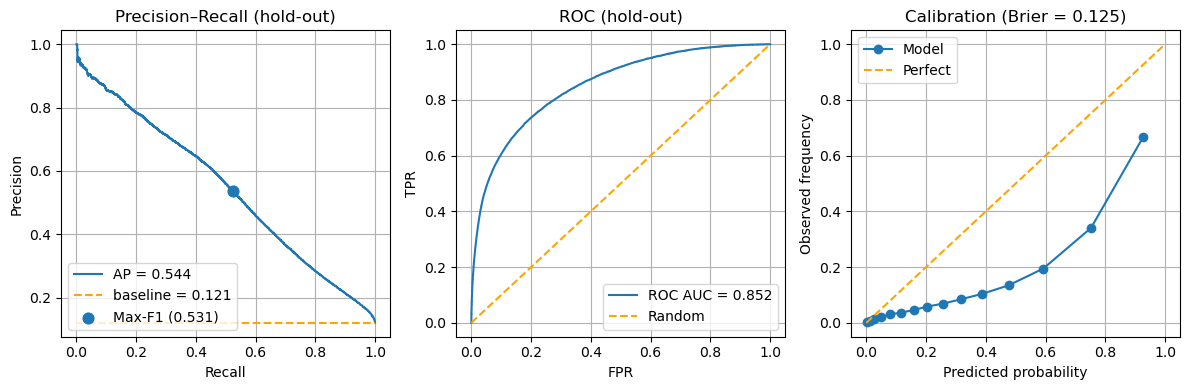

In [119]:
# -----------------------------
# Step 1: Load the deployed artifact (production model)
# -----------------------------
model = joblib.load("model.joblib")

# -----------------------------
# Step 2: Predict probabilities on the hold-out set
# -----------------------------
proba_va = model.predict_proba(X_va)[:, 1]

# -----------------------------
# Step 3: Main metric (PR-AUC) and complementary ones
# -----------------------------
ap  = average_precision_score(y_va, proba_va)
roc = roc_auc_score(y_va, proba_va)
ll  = log_loss(y_va, proba_va)
br  = brier_score_loss(y_va, proba_va)

print(f"[Hold-out] PR-AUC: {ap:.4f} | ROC-AUC: {roc:.4f} | LogLoss: {ll:.4f} | Brier: {br:.4f}")

# -----------------------------
# Step 4: Threshold selection (A: Max-F1 | B: Top k% by budget)
# -----------------------------
prec, rec, ths = precision_recall_curve(y_va, proba_va)

# Avoid division by zero and handle the case with no points
f1_scores = (2 * prec[:-1] * rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-9) if len(prec) > 1 else np.array([])

if len(f1_scores):
    best_idx  = int(np.argmax(f1_scores))
    best_th_f1 = float(ths[best_idx])
    best_f1    = float(f1_scores[best_idx])
    print(f"[Threshold] Max-F1 threshold: {best_th_f1:.4f}")
else:
    best_th_f1 = 0.5
    print("[Threshold] Could not compute F1; using default threshold 0.5")

CALL_BUDGET_RATE = 0.10  # e.g., contact the top 10% highest scores
th_budget = float(np.quantile(proba_va, 1 - CALL_BUDGET_RATE))
print(f"[Threshold] Budget-based (top {int(CALL_BUDGET_RATE*100)}%) threshold: {th_budget:.4f}")

# -----------------------------
# Step 5: Confusion matrices and reports at both thresholds
# -----------------------------
def evaluate_at_threshold(y_true, proba, threshold, label):
    y_pred = (proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    print(f"\n[{label}] threshold={threshold:.4f}")
    print("Confusion matrix:\n", cm)
    print(classification_report(y_true, y_pred, digits=4))

evaluate_at_threshold(y_va, proba_va, best_th_f1, "Max-F1")
evaluate_at_threshold(y_va, proba_va, th_budget, "Budget-based")

# -----------------------------
# Step 6: Curves (ROC, Precision–Recall, Calibration)
# -----------------------------
# Metrics
rocauc = roc_auc_score(y_va, proba_va)
ap = average_precision_score(y_va, proba_va)
baseline = y_va.mean()
br = brier_score_loss(y_va, proba_va)

# Base curves
fpr, tpr, _ = roc_curve(y_va, proba_va)
prec, rec, ths = precision_recall_curve(y_va, proba_va)
prob_true, prob_pred = calibration_curve(y_va, proba_va, n_bins=15, strategy="quantile")

# Max-F1 point on PR curve
with np.errstate(divide='ignore', invalid='ignore'):
    f1 = 2 * prec[:-1] * rec[:-1] / (prec[:-1] + rec[:-1] + 1e-9)
best_idx = f1.argmax() if f1.size else None

# Side-by-side plots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# --- Precision–Recall ---
ax = axes[0]
ax.plot(rec, prec, label=f"AP = {ap:.3f}")
ax.hlines(baseline, 0, 1, linestyles="--", label=f"baseline = {baseline:.3f}", color="orange")
if best_idx is not None:
    ax.scatter(rec[:-1][best_idx], prec[:-1][best_idx], s=60, zorder=3, label=f"Max-F1 ({f1[best_idx]:.3f})")
ax.set(xlabel="Recall", ylabel="Precision", title="Precision–Recall (hold-out)")
ax.legend(loc="lower left")

# --- ROC ---
ax = axes[1]
ax.plot(fpr, tpr, label=f"ROC AUC = {rocauc:.3f}")
ax.plot([0, 1], [0, 1], "--", label="Random", color="orange")
ax.set(xlabel="FPR", ylabel="TPR", title="ROC (hold-out)")
ax.legend(loc="lower right")

# --- Calibration ---
ax = axes[2]
ax.plot(prob_pred, prob_true, marker="o", label="Model")
ax.plot([0, 1], [0, 1], "--", label="Perfect", color="orange")
ax.set(xlabel="Predicted probability", ylabel="Observed frequency", title=f"Calibration (Brier = {br:.3f})")
ax.legend()

plt.tight_layout()
plt.show()

The model shows **strong discrimination power** with a ROC-AUC of **0.85**, indicating it separates subscribers from non-subscribers well.  
The **PR-AUC (0.54)** is modest but reasonable given the class imbalance, meaning the model still adds value in identifying the rare subscribers.  
Both **LogLoss (0.39)** and **Brier score (0.125)** suggest good probability calibration.

- **Max-F1 threshold (0.7041):** Achieves a balanced trade-off between precision (0.54) and recall (0.52). This is useful when the business wants to maximize efficiency across both objectives.  
- **Budget-based threshold (top 10%, 0.7508):** Increases precision (0.58) at the cost of recall (0.48). This is better aligned with limited calling resources, ensuring fewer wasted calls.

For broad campaigns, the **Max-F1** cutoff is suitable, while for resource-constrained operations, the **Budget-based threshold** is the more practical choice.